In [1]:
from utils import *
import pandas as pd
import os

### Script parameters
- Language: supported 'it' and 'en'
- Model name: the model to use
- Rollout: if to apply rollout to ValueZeroing
- Aggregation method: how to compute the attention of a word composed of multiple sub-tokens. Supported values:
	- sum: sum attention values of all sub-tokens
	- max: take the maximum attention value among sub-tokens
	- mean: average the attention values of the sub-tokens
	- first: take the attention value of the first sub-token
- Layer: the layer from which to extract attention

In [2]:
language = 'it'
rollout = True
aggregation_method = 'first'
layer = 11
model_name = 'xlm-roberta-base'
subword_prefix = '▁' #'Ġ' 
method = 'attention'

In [3]:
eye_tracking_data_dir = f'../../augmenting_nlms_meco_data/{language}'

out_dir = f'output/attn_data/value_zeroing/{language}/{model_name}'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

out_file_name = f'{aggregation_method}' if not rollout else f'{aggregation_method}_rollout'
out_file_name += f'_l{layer}.json'
out_path = os.path.join(out_dir, out_file_name)
out_path

'data/value_zeroing/it/xlm-roberta-base/first_rollout_l11.json'

In [4]:
dl = EyeTrackingDataLoader(eye_tracking_data_dir)
sentences_df = dl.load_sentences()

In [5]:
sentences_df

,sent_id,sentence
0,1_1,"[Negli, antichi, miti, e, religioni, Romane,, ..."
1,1_2,"[Egli, ha, una, doppia, natura, ed, è, solitam..."
2,1_3,"[Giano, presiede, sull’inizio, e, sulla, fine,..."
3,1_4,"[Le, porte, del, suo, tempio, erano, aperte, i..."
4,1_5,"[Come, dio, dei, cancelli,, era, anche, associ..."
...,...,...
85,12_4,"[L'identificativo, di, registrazione, è, una, ..."
86,12_5,"[In, alcuni, paesi,, l'identificativo, è, univ..."
87,12_6,"[La, Francia, fu, il, primo, paese, ad, introd..."
88,12_7,"[Le, targhe, dei, primi, del, novecento, varia..."


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

Create a mapping of indices to align model's tokens and sub-tokens to original words

In [7]:
def align_to_original_words(model_tokens: list, original_tokens: list, subword_prefix: str,
                            lowercase: bool = False) -> list:
    if lowercase:
        original_tokens = [tok.lower() for tok in original_tokens]
    model_tokens = model_tokens[1: -1]  # Remove <s> and </s>
    aligned_model_tokens = []
    alignment_ids = []
    alignment_id = -1
    orig_idx = 0
    for token in model_tokens:
        alignment_id += 1
        if token.startswith(subword_prefix):  # Remove the sub-word prefix
            token = token[len(subword_prefix):]
        if len(aligned_model_tokens) == 0:  # First token (serve?)
            aligned_model_tokens.append(token)
        elif aligned_model_tokens[-1] + token in original_tokens[
            orig_idx]:  # We are in the second (third, fourth, ...) sub-token
            aligned_model_tokens[-1] += token  # so we merge the token with its preceding(s)
            alignment_id -= 1
        else:
            aligned_model_tokens.append(token)
        if aligned_model_tokens[-1] == original_tokens[
            orig_idx]:  # A token was equal to an entire original word or a set of
            orig_idx += 1  # sub-tokens was merged and matched an original word
        alignment_ids.append(alignment_id)

    if aligned_model_tokens != original_tokens:
        raise Exception(
            f'Failed to align tokens.\nOriginal tokens: {original_tokens}\nObtained alignment: {aligned_model_tokens}')
    return alignment_ids

In [8]:
def create_subwords_alignment(sentences_df: pd.DataFrame, tokenizer: AutoTokenizer, subword_prefix: str,
                              lowercase: bool = False) -> dict:
    sentence_alignment_dict = dict()

    for idx, row in sentences_df.iterrows():
        sent_id = row['sent_id']
        sentence = row['sentence']
        for tok_id, tok in enumerate(sentence):
            if tok == '–':
                sentence[tok_id] = '-'
        if lowercase:
            sentence = [word.lower() for word in sentence]
        tokenized_sentence = tokenizer(sentence, is_split_into_words=True, return_tensors='pt')
        input_ids = tokenized_sentence['input_ids'].tolist()[0]  # 0 because the batch_size is 1
        model_tokens = tokenizer.convert_ids_to_tokens(input_ids)
        alignment_ids = align_to_original_words(model_tokens, sentence, subword_prefix, lowercase)
        sentence_alignment_dict[sent_id] = {'model_input': tokenized_sentence, 'alignment_ids': alignment_ids}
    return sentence_alignment_dict

In [9]:
sentence_alignment_dict = create_subwords_alignment(sentences_df, tokenizer, subword_prefix)

In [11]:
if method == 'valuezeroing':
    attn_extractor = ValueZeroingContributionExtractor(model_name, layer, rollout, aggregation_method, 'cpu')
elif method == 'alti':
    attn_extractor = AltiContributionExtractor(model_name, layer, rollout, aggregation_method, 'cpu')
else:
    attn_extractor = AttentionMatrixExtractor(model_name, layer, rollout, aggregation_method, 'cpu')

In [12]:
sentences_contribs = attn_extractor.get_contributions(sentence_alignment_dict)

100%|██████████| 90/90 [00:08<00:00, 10.07it/s]


In [13]:
import matplotlib.pyplot as plt
def plot_contributions(tokens, contributions):
    plt.bar(tokens, contributions)
    plt.xticks(rotation=90)

In [14]:
sentence = sentences_df[sentences_df['sent_id']=='1_1']['sentence'].tolist()[0]
contribs = sentences_contribs['1_1']

In [15]:
contribs

[0.01941528730094433,
 0.019268620759248734,
 0.03054790198802948,
 0.02190074883401394,
 0.018786562606692314,
 0.031822435557842255,
 0.04798063635826111,
 0.0197459664195776,
 0.03754480555653572,
 0.028361359611153603,
 0.031376320868730545,
 0.023438503965735435,
 0.022536689415574074,
 0.032102908939123154,
 0.029321059584617615]

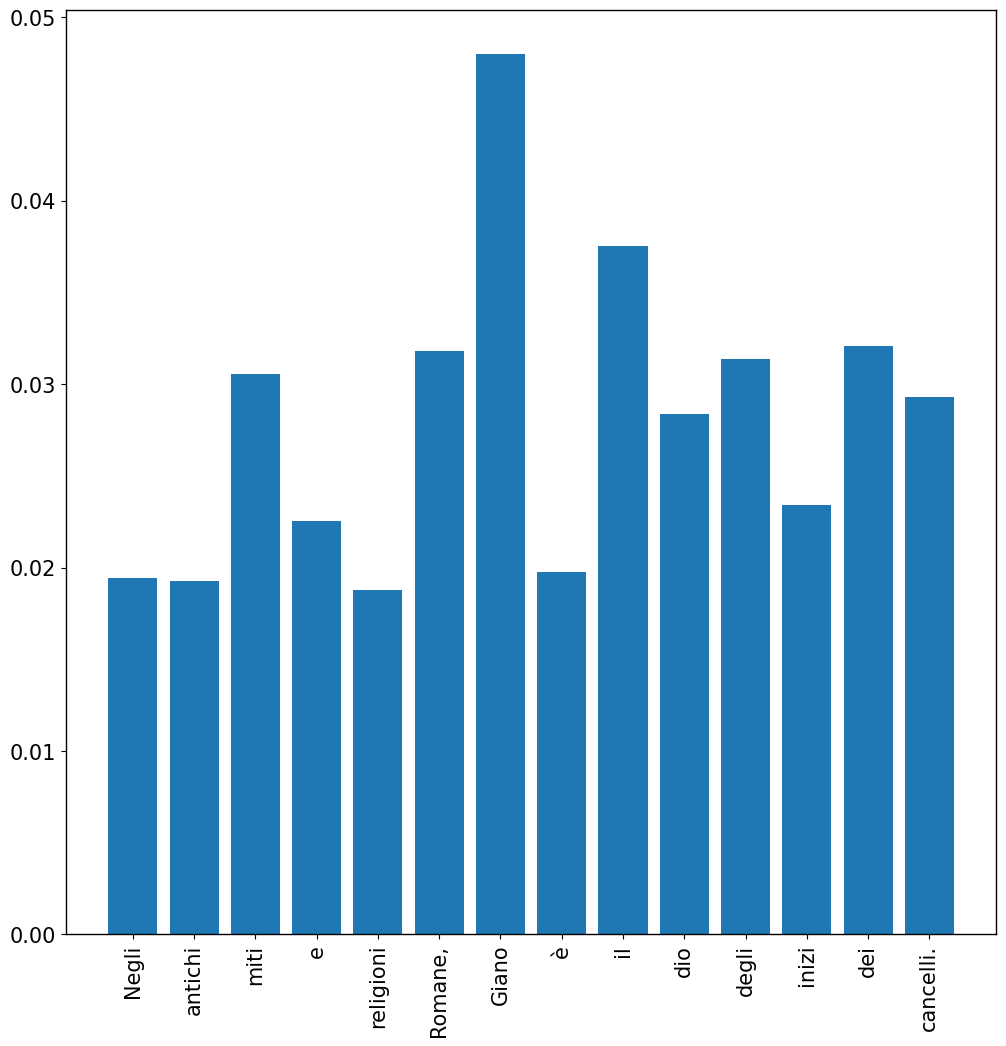

In [16]:
plot_contributions(sentence, contribs)

In [17]:
out_path = 'output/attn_data/value_zeroing/en/roberta-base/puppa.json'

In [22]:
import json
def save_dictionary(dictionary, out_path):
    with open(out_path, 'w') as out_file:
        out_file.write(json.dumps(dictionary))

In [23]:
save_dictionary(sentences_contribs, out_path)